In [1]:
%matplotlib inline

In [2]:
import os, json, tabix, itertools, gzip, ast, subprocess, pickle, math
import itertools as it
import pyfasta
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib as mpl
import gc
import colorbrewer
from collections import OrderedDict as odict
from matplotlib import pyplot as plt
from hs_vervet.scripts import vcf_parser as vp
from hs_vervet.tools import hs_pandas as hpd
eu = os.path.expanduser
jn = os.path.join

var_ana_dir = eu("~/vervet_project/analyses/20150504_163_UnifiedGenotyper/_data")
meta_dir = eu("~/vervet_project/metadata")
balancing_sel_dir = eu("~/vervet_project/analyses/20150520_popgen_analysis_UG/")
xpclr_ana_dir = eu("~/vervet_project/analyses/20150528_UG_xpclr/_data") 
man_ana_dir = eu("~/vervet_project/analyses/20150520_popgen_analysis_UG/_data")
manuscript_dir = eu("~/VervetPopgen/Manuscript/VervetPopgen_man")
manuscript_dir2 = eu("~/VervetPopgen/Manuscript/VervetPopgen_man_0_2")

ballet_dir = eu("~/vervet_project/analyses/20150601_UG_ballet/_data")
figure_dir = eu("~/VervetPopgen/Figures")
alignment_dir = eu("~/vervet_project/data/alignments/163_non_VRC_vs_ref_3500/")
presentation_dir = eu("~/VervetPopgen/Presentations")

popgen_dir = eu("~/vervet_project/analyses/20150520_popgen_analysis_UG/_data")

admixtools_dir = eu("~/vervet_project/analyses/20160330_admixtools/_data")

bc = [[i/255. for i in c] for c in  colorbrewer.Set1[8]]
color_dic = {"aet":bc[1],"cyn":bc[7],"pyn":bc[3],"pyg":bc[2],"pys":bc[2],"sab":bc[4],"sac":bc[5],"sar":bc[6],"tan":bc[0]}

pops = ["aet","cyn","pyn","sab","tan"]
#colors = ["blue","magenta","cyan","green","orange","red"]
colors = [color_dic[p] for p in pops]

pops0 = ["aet","cyn","pyn","pys","sab","tan"]
#colors = ["blue","magenta","cyan","green","orange","red"]
colors0 = [color_dic[p] for p in pops0]

pops2 = ["aet","cyn","pyn","pys","sab","sac","tan"]
#colors2 = ["blue","magenta","cyan","green","orange","yellow","red"]
colors2 = [color_dic[p] for p in pops2]
pops3 = ["aet","cyn","pyn","pys","sab","sac","sar","tan"]
colors3 = ["blue","magenta","cyan","green","orange","yellow","brown","red"]
markers3 = ['D','s','v','>','p','h','^','o']

colors3 = [color_dic[p] for p in pops3]
#converter =  mpl.colors.ColorConverter()
#colors3_rgb = [converter.to_rgb(c) for c in colors3]

autosomes = ["CAE" + str(i) for i in range(1,30)]
chromosomes = ["CAE" + str(i) for i in range(1,30)+["X","Y"]]

mu=1.5e-8
generation_time = 8.5

neff = json.load(open(jn(var_ana_dir,"n_eff_pop3.json")))

chrom_length = pd.read_csv(jn(meta_dir,"ref3500.tsv"), sep='\t', squeeze=True, index_col=0)

cov_df = pd.read_csv(jn(meta_dir,"163_vs_ref_3500_coverage.tsv"),sep="\t",index_col=0)

def str_to_dic(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        print s
        raise
        
mt = pd.read_csv(jn(meta_dir,"163_master_table.csv"),
                 index_col=0,
                 converters={"library":str_to_dic,"phenotypes":str_to_dic}
                 )

#africa_ids = mt[mt['pop2']!='sac'].index.values
ucla_ids = mt.index.values
countries = mt['country'].unique()

In [3]:
def get_ad_df(chrom):
    """
    get 0,1,2 genotype data frame
    """
    fn = jn(var_ana_dir,"163_UG_ref3500_anc_der_including_fixed_{}.tsv".format(chrom))
    df = pd.read_csv(fn,index_col=[0,1],sep="\t",na_values="N")
    return df

In [38]:
chrom = "CAE28"
ad_df = get_ad_df(chrom)

In [39]:
eigenstrat_df = ad_df.replace({0:2,2:0}).fillna(9)
eigenstrat_df["macaque"] = 2

In [32]:
eigenstrat_df.iloc[:10].to_string?

Object `to_string` not found.


In [40]:
t = eigenstrat_df.iloc[:10]

In [64]:
len('139301422')

9

In [172]:
prefix = "163_mac_anc_der_CAE1_24"
name = "countries"

In [173]:
ind_df = mt.copy()

ind_df.loc[ind_df["country"]=="Central African Republic","country"] = 'Central_African_Republic'
ind_df.loc[ind_df["country"]=="South Africa","country"] = 'South_Africa'
ind_df.loc[ind_df["country"]=="Saint Kitts","country"] = 'Saint_Kitts'
ind_df.loc['macaque'] = np.nan
ind_df.loc['macaque','country'] = 'macaque'
ind_df["sex"] = 'M' #this is not true but sex info not needed for admixtools!
ind_df[["sex","country"]].to_csv(jn(admixtools_dir,prefix+".ind"),sep='\t',header=False)

In [170]:
prefix

'163_mac_anc_der'

In [ ]:
just = 0
with open(jn(admixtools_dir,prefix + ".eigenstratgeno"),'w') as genof, \
     open(jn(admixtools_dir,prefix + ".snp"),'w') as snpof:   
    for chrom in chromosomes[:24]:
        ad_df = get_ad_df(chrom)
        eigenstrat_df = ad_df.replace({0:2,2:0}).fillna(9)
        eigenstrat_df["macaque"] = 2
        cl = chrom_length.ix[chrom]
        chrom_num = chrom[3:]
        for (chrom,pos), row in eigenstrat_df.iterrows():
            #write eigenstratgeno
            genof.write("".join([str(int(i)) for i in row.values]) + '\n')
            id = (chrom + '_' + str(pos))
            #the allelles A,T are arbitrary, but should not be used by admixtools
            snpof.write(" ".join([str(s).rjust(just) for s in [id,22,"{:.6f}".format(pos*1./cl,pos),pos,'A','T']])+'\n')


In [95]:
admixtools_dir

'/home/GMI/hannes.svardal/vervet_project/analyses/20160330_admixtools/_data'

In [8]:
from Bio import Phylo
import StringIO
import re
import itertools
import copy

In [9]:
#tree manipulation
def get_tree_str(tree):
    f = StringIO.StringIO()
    Phylo.write(tree, f, format='newick')
    f.seek(0)
    return f.read()

def prune_tree_to_populations(in_tree, population_dict):
    tree = copy.deepcopy(in_tree)
    for pop, names in population_dict.iteritems():
        try:
            [i for i in tree.find_clades(names[0])][0].name = pop
        except IndexError:
            print "could not find clade", names[0]
            print  [i for i in tree.find_clades(names[0])]
        for n in names[1:]:
            tree.prune(target=n)
    return tree

def consistent_with_tree(tree, h1,h2,h3,o):
    if tree.distance(h1,h2) < tree.distance(h2,h3) and \
               tree.distance(h1,h2) < tree.distance(h1,h3) and \
               tree.distance(h2,h3) < tree.distance(h2,o) and \
               tree.distance(h1,h3) < tree.distance(h1,o):
            return True
    else:
        return False

In [10]:
from ete2 import Tree

In [613]:
Phylo

<module 'Bio.Phylo' from '/home/GMI/hannes.svardal/lib/python/virtualenvs/ver/lib/python2.7/site-packages/Bio/Phylo/__init__.py'>

(-0.30000000000000004, 7.5, 9.3000000000000007, 0.20000000000000001)

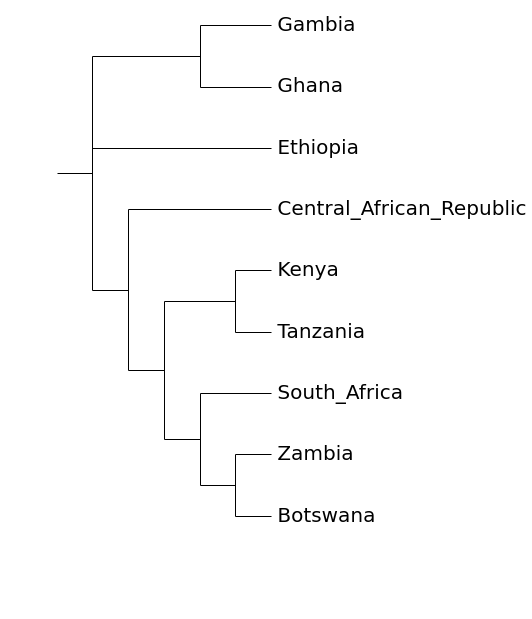

In [11]:
country_tree_str = ("(((((Nevis:8.968087352e-05,Saint_Kitts:8.968087352e-05):9.695564516e-05,Gambia:0.0001866365187)"
                                    ":7.463233541e-05,Barbados:0.0002612688541):6.172117714e-05,Ghana:0.0003229900312):0.0007033299895,"
                                    "(Ethiopia:0.0007779845646,(Central_African_Republic:0.0005067399856,((Kenya:0.0001226972008,Tanzania:"
                                    "0.0001226972008):0.0001846822912,(South_Africa:0.0002040078734,(Zambia:0.0001606286963,"
                                    "Botswana:0.0001606286963):4.337917708e-05):0.0001033716185):0.0001993604937):0.000271244579):"
                                    "0.0002483354561);")


country_tree_str = ("((((Nevis,Saint_Kitts),Gambia)"
                                    ",Barbados),Ghana),"
                                    "Ethiopia,(Central_African_Republic,((Kenya,Tanzania:"
                                    "),(South_Africa,(Zambia,"
                                    "Botswana))));")

country_tree_str = ("(Gambia:2,Ghana:2):3,"
                                    "Ethiopia:5,(Central_African_Republic:4,((Kenya,Tanzania"
                                    "):2,(South_Africa:2,(Zambia,"
                                    "Botswana))));")

country_tree = Phylo.read(StringIO.StringIO(country_tree_str),"newick")
#tree_upgma_pi_minus_within_country.root_with_outgroup("macaque")
fig = plt.figure(figsize=(5,10))
ax = plt.gca()
ax = Phylo.draw(country_tree,axes=ax, do_show=False)#,label_func=lambda s:s
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.tick_params(axis=u'both', which=u'both',length=0)
plt.axis('off')
#plt.savefig(jn(manuscript_dir2,"images","country_tree.svg"))

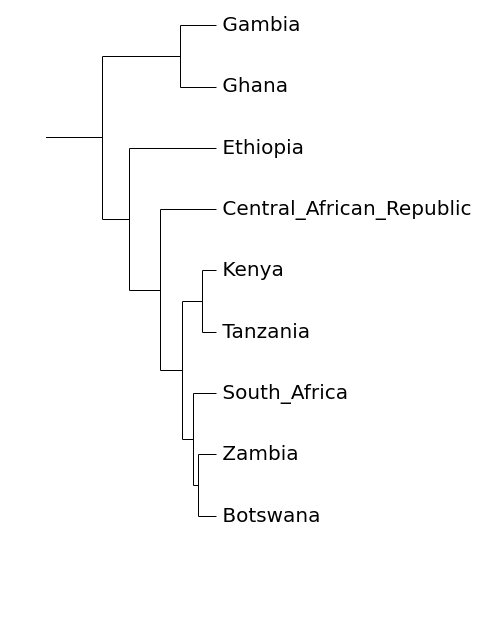

In [12]:
upgma_pi_minus_within_country_str = ("(((((Nevis:8.968087352e-05,Saint_Kitts:8.968087352e-05):9.695564516e-05,Gambia:0.0001866365187)"
                                    ":7.463233541e-05,Barbados:0.0002612688541):6.172117714e-05,Ghana:0.0003229900312):0.0007033299895,"
                                    "(Ethiopia:0.0007779845646,(Central_African_Republic:0.0005067399856,((Kenya:0.0001226972008,Tanzania:"
                                    "0.0001226972008):0.0001846822912,(South_Africa:0.0002040078734,(Zambia:0.0001606286963,"
                                    "Botswana:0.0001606286963):4.337917708e-05):0.0001033716185):0.0001993604937):0.000271244579):"
                                    "0.0002483354561);")
upgma_pi_minus_within_country_str = ("((((((Nevis:8.968087352e-05,Saint_Kitts:8.968087352e-05):9.695564516e-05,Gambia:0.0001866365187)"
                                    ":7.463233541e-05,Barbados:0.0002612688541):6.172117714e-05,Ghana:0.0003229900312):0.0007033299895,"
                                    "(Ethiopia:0.0007779845646,(Central_African_Republic:0.0005067399856,((Kenya:0.0001226972008,Tanzania:"
                                    "0.0001226972008):0.0001846822912,(South_Africa:0.0002040078734,(Zambia:0.0001606286963,"
                                    "Botswana:0.0001606286963):4.337917708e-05):0.0001033716185):0.0001993604937):0.000271244579):"
                                    "0.0002483354561),(macaque:2));")#.replace({"Saint_Kitts":"STK"}))
upgma_pi_minus_within_country_str = ("(((((Nevis:8.968087352e-05,Saint_Kitts:8.968087352e-05):9.695564516e-05,Gambia:0.0001866365187)"
                                    ":7.463233541e-05,Barbados:0.0002612688541):6.172117714e-05,Ghana:0.0003229900312):0.0007033299895,"
                                    "(Ethiopia:0.0007779845646,(Central_African_Republic:0.0005067399856,((Kenya:0.0001226972008,Tanzania:"
                                    "0.0001226972008):0.0001846822912,(South_Africa:0.0002040078734,(Zambia:0.0001606286963,"
                                    "Botswana:0.0001606286963):4.337917708e-05):0.0001033716185):0.0001993604937):0.000271244579):"
                                    "0.0002483354561);")
tree_upgma_pi_minus_within_country = Phylo.read(StringIO.StringIO(upgma_pi_minus_within_country_str),"newick")
tree_upgma_pi_minus_within_country.prune("Saint_Kitts")
tree_upgma_pi_minus_within_country.prune("Nevis")
tree_upgma_pi_minus_within_country.prune("Barbados")
fig = plt.figure(figsize=(5,10))

ax = plt.gca()
Phylo.draw(tree_upgma_pi_minus_within_country,axes=ax,do_show=False)
ax.set_xlim([0.9995,1.002])
plt.axis('off')
plt.savefig(jn(manuscript_dir2,"images","country_tree.png"))

In [13]:
tree = tree_upgma_pi_minus_within_country

In [144]:
print list(mt.country.unique()) + ['macaque']

['Barbados', 'Tanzania', 'Central African Republic', 'Saint Kitts', 'Botswana', 'Ethiopia', 'Gambia', 'Ghana', 'Kenya', 'South Africa', 'Nevis', 'Zambia', 'macaque']


In [174]:
prefix = "163_mac_anc_der_CAE1_24"
name = "countries"
populations = ['Barbados', 'Tanzania', 'Central_African_Republic', 
 'Saint_Kitts', 'Botswana', 'Ethiopia', 'Gambia', 'Ghana', 
 'Kenya', 'South_Africa', 'Nevis', 'Zambia', 'macaque']
tree = tree_upgma_pi_minus_within_country
outgroups = ["macaque","Gambia"]

with open(jn(admixtools_dir,prefix + '_' + name +  ".dstat.par"),'w') as f:
    f.write("genotypename:   {}.eigenstratgeno\n".format(prefix))
    f.write("snpname:   {}.snp\n".format(prefix))
    f.write("indivname:   {}.ind\n".format(prefix))
    f.write("poplistname:  {}_{}.dstat.populations\n".format(prefix, name))
    f.write("popfilename:   {}_{}.dstat.tests\n".format(prefix, name))
    
with open(jn(admixtools_dir,prefix + '_' + name + ".dstat.populations"),'w') as f:
    for c in populations:
        f.write(c + '\n')
        
consistent_quadrupels = []
for tpl in itertools.combinations(populations,4):
    for h1,h2,h3,o in itertools.permutations(tpl):
        try:
            if consistent_with_tree(tree, h1,h2,h3,o) and \
                (h1,h2,h3,o) not in consistent_quadrupels and o in outgroups:
                    consistent_quadrupels.append((h2,h1,h3,o)) 
        except ValueError:
            print h1,h2,h3,o
            
with open(jn(admixtools_dir,prefix + '_' + name +".dstat.tests"),'w') as f:
    f.write("\n".join(['\t'.join(t) for t in consistent_quadrupels]))

## Analyse results

In [24]:
admixtools_dir

'/home/GMI/hannes.svardal/vervet_project/analyses/20160330_admixtools/_data'

In [4]:
#analyse

def load_result(prefix, name):
    return pd.read_csv(jn(admixtools_dir,prefix + '_' + name + '.dstat.result'),
                           sep='\t', header=None, names=['h1','h2','h3','o','dstat','Z','BABA','ABBA','n_snps'])

def add_partner_control(dstat_df):
    dstat_df['|dstat|'] = dstat_df['dstat'].apply(abs)
    dstat_df['|Z|'] = dstat_df['Z'].apply(abs)
    #the one that shows geneflow with h3
    dstat_df["admixture_partner"] = dstat_df["h1"]*(dstat_df["dstat"]>0) + dstat_df["h2"]*(dstat_df["dstat"]<0)
    #the other
    dstat_df["control_ingroup"] = dstat_df["h1"]*(dstat_df["dstat"]<0) + dstat_df["h2"]*(dstat_df["dstat"]>0)
    #dstat_df.set_index(["admixture_partner","h3"],inplace=True)
    return dstat_df

def get_partner_vs_control_matrix(dstat_df):
    partner_vs_control = single_h3_df.groupby(['admixture_partner','control_ingroup']).apply(lambda df:df['|dstat|'].iloc[0])
    partner_vs_control = partner_vs_control.unstack()
    return partner_vs_control


def get_admixture_stats(dstat_df, summary_fun):
    mean_gene_flow = dstat_df.groupby(['admixture_partner','h3']).apply(summary_fun)
    return mean_gene_flow

def mean_over_control_ingroups(df):
    mean_df = df[['|Z|','|dstat|']].mean()
    return mean_df
def max_over_control_ingroups(df):
    mean_df = df[['|Z|','|dstat|']].max()
    mean_df['max_control'] = df['control_ingroup'].loc[df['|dstat|'].argmax()]
    return mean_df

def plot_mat(pw_df):
    d = np.ma.array(pw_df.values, mask=pw_df.isnull().values)
    plt.pcolor(d)
    plt.colorbar()
    ax = plt.gca()
    tick_locations = np.arange(0.5, len(pw_df)+1)
    ax.set_xticks(tick_locations)
    ax.set_yticks(tick_locations)
    ax.set_xticklabels(pw_df.columns, rotation='vertical')
    ax.set_yticklabels(pw_df.index)
    ax.set_xlabel(pw_df.columns.name)
    ax.set_ylabel(pw_df.index.name)
    return ax


def plot_mat_control(gene_flow,stat='|dstat|',pop_order=None, pop_order_x=None, pop_order_y=None):
    d = gene_flow[stat].unstack()
    max_control = gene_flow["max_control"].unstack()
    if pop_order_x is not None and pop_order_y is not None:
        d = d.loc[pop_order_x,pop_order_y]
        max_control = max_control.loc[pop_order_x,pop_order_y]
    elif pop_order is not None:
        d = d.loc[pop_order,pop_order]
        max_control = max_control.loc[pop_order,pop_order]
    plot_mat(d)
    for x in range(max_control.shape[1]):
        for y in range(max_control.shape[0]):
            try:
                text = max_control.iloc[y,x][:3]
            except TypeError:
                text = ''
            plt.annotate(text,(x+0.5,y+0.5),horizontalalignment='center', verticalalignment='center')

In [5]:
caribbean = ["Nevis","Saint_Kitts","Barbados"]

In [187]:
~dstat_df[['h1','h2','h3']].applymap(lambda c: c in caribbean).any(axis=1)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
...
324     True
325    False
326    False
327     True
328    False
329     True
330    False
331     True
332    False
333     True
334    False
335    False
336     True
337    False
338    False
Length: 339, dtype: bool

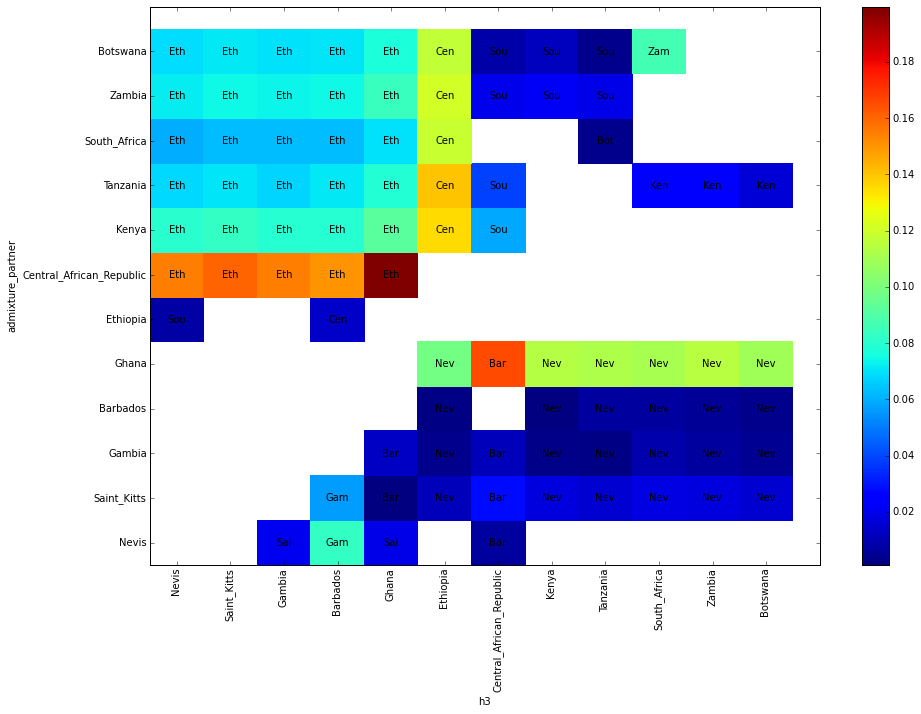

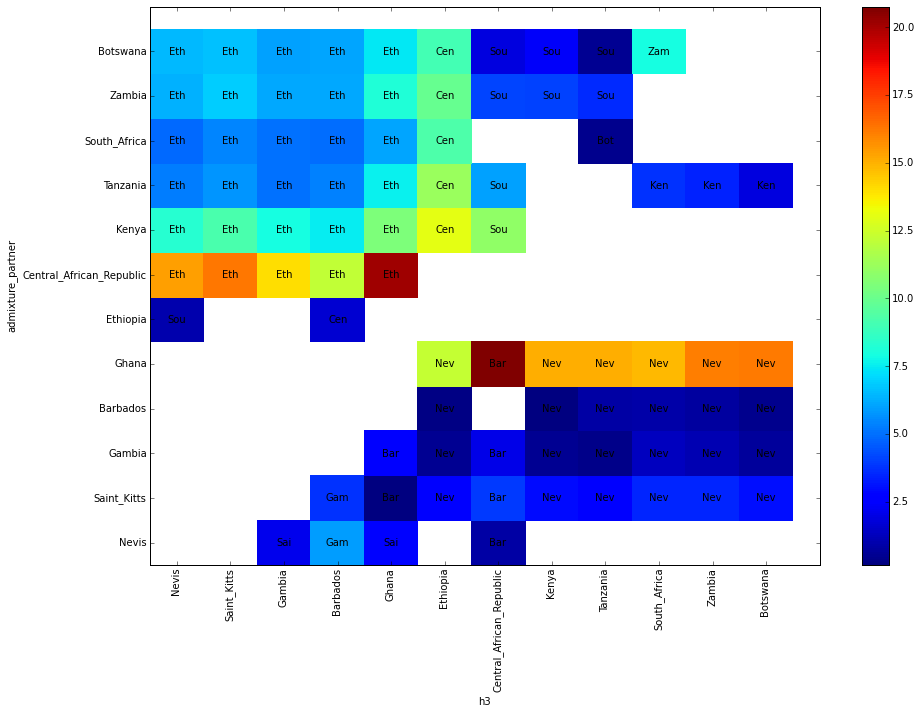

In [180]:
prefix = "163_mac_anc_der"
name = "CAE1"
dstat_df = load_result(prefix, name)
dstat_df = add_partner_control(dstat_df)

gene_flow = dstat_df.groupby(['admixture_partner','h3']).apply(max_over_control_ingroups)

pop_tree_order = [c.name for c in tree.get_terminals()]
order = [o for o in pop_tree_order if o not in ['macaque']]
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order)
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order,stat='|Z|')

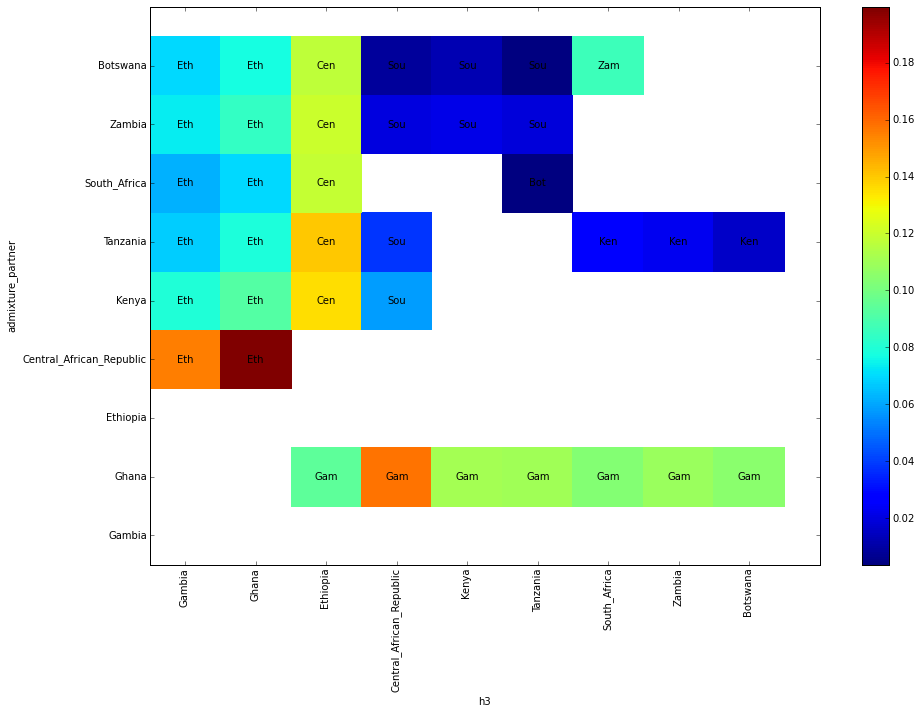

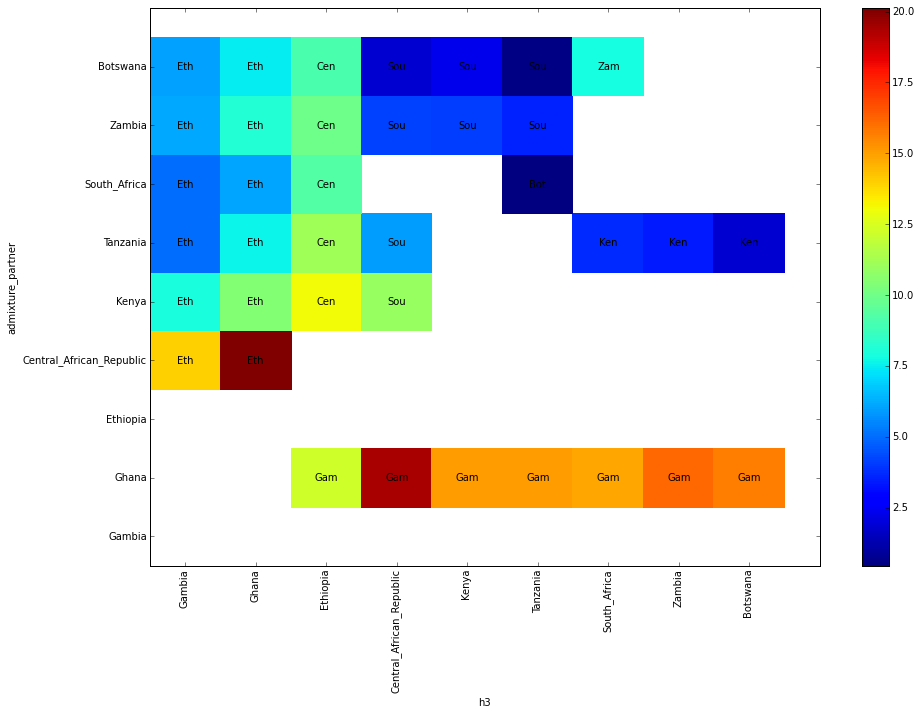

In [192]:
prefix = "163_mac_anc_der"
name = "CAE1"
dstat_df = load_result(prefix, name)
dstat_df = add_partner_control(dstat_df)
dstat_df_non_carib = dstat_df[~dstat_df[['h1','h2','h3']].applymap(lambda c: c in caribbean).any(axis=1)]

gene_flow = dstat_df_non_carib.groupby(['admixture_partner','h3']).apply(max_over_control_ingroups)

pop_tree_order = [c.name for c in tree.get_terminals()]
order = [o for o in pop_tree_order if o not in ['macaque']+caribbean]
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order)
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order,stat='|Z|')

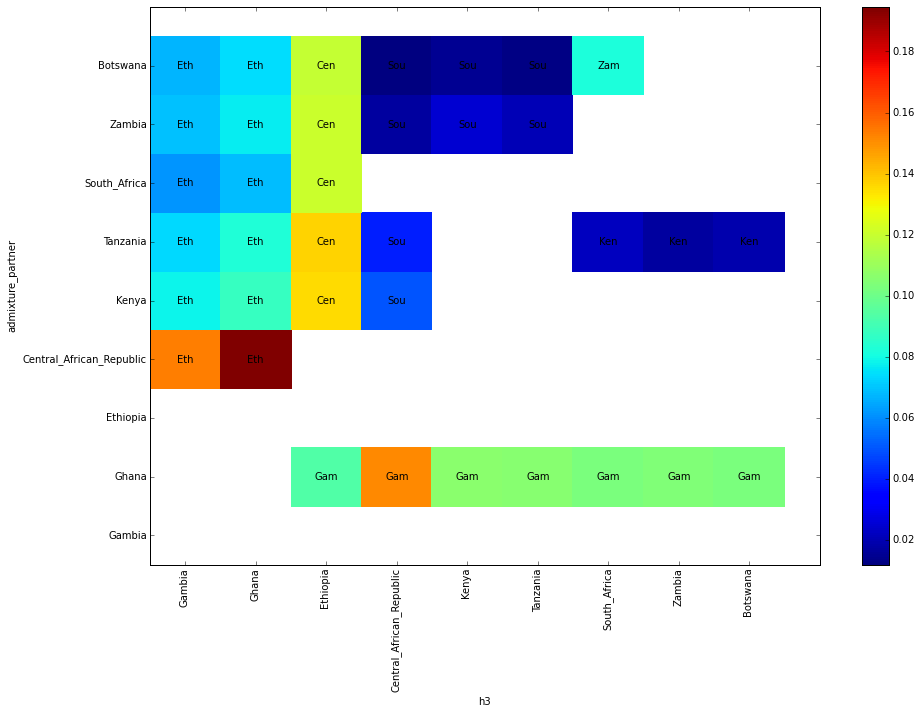

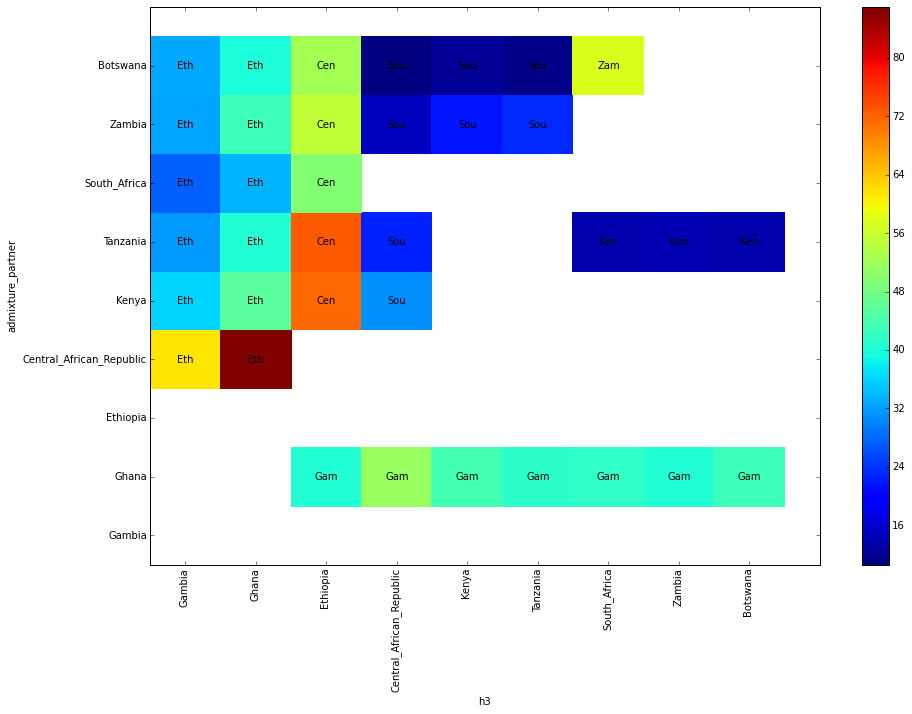

In [194]:
prefix = "163_mac_anc_der_CAE1_24"
name = "countries"
dstat_df = load_result(prefix, name)
dstat_df = add_partner_control(dstat_df)
dstat_df_non_carib = dstat_df[~dstat_df[['h1','h2','h3']].applymap(lambda c: c in caribbean).any(axis=1)]

gene_flow = dstat_df_non_carib.groupby(['admixture_partner','h3']).apply(max_over_control_ingroups)

pop_tree_order = [c.name for c in tree.get_terminals()]
order = [o for o in pop_tree_order if o not in ['macaque']+caribbean]
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order)
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order,stat='|Z|')

In [ ]:
prefix = "163_mac_anc_der_"
name = "CAE1"
dstat_df = load_result(prefix, name)
dstat_df = add_partner_control(dstat_df)
dstat_df_non_carib = dstat_df[~dstat_df[['h1','h2','h3']].applymap(lambda c: c in caribbean).any(axis=1)]

gene_flow = dstat_df_non_carib.groupby(['admixture_partner','h3']).apply(max_over_control_ingroups)

pop_tree_order = [c.name for c in tree.get_terminals()]
order = [o for o in pop_tree_order if o not in ['macaque']+caribbean]
fig = plt.figure(figsize=(15,10))

In [11]:
def plot_bubbles(gene_flow,stat='|dstat|',pop_order=None, pop_order_x=None, pop_order_y=None):
    d = gene_flow[stat].unstack()
    max_control = gene_flow["max_control"].unstack()
    if pop_order_x is not None and pop_order_y is not None:
        d = d.loc[pop_order_x,pop_order_y]
        max_control = max_control.loc[pop_order_x,pop_order_y]
    elif pop_order is not None:
        d = d.loc[pop_order,pop_order]
        max_control = max_control.loc[pop_order,pop_order]
    plot_mat(d)
    for x in range(max_control.shape[1]):
        for y in range(max_control.shape[0]):
            try:
                text = max_control.iloc[y,x][:3]
            except TypeError:
                text = ''
            plt.annotate(text,(x+0.5,y+0.5),horizontalalignment='center', verticalalignment='center')

prefix = "163_mac_anc_der"
name = "CAE1"
dstat_df = load_result(prefix, name)
dstat_df = add_partner_control(dstat_df)
dstat_df_non_carib = dstat_df[~dstat_df[['h1','h2','h3']].applymap(lambda c: c in caribbean).any(axis=1)]

gene_flow = dstat_df_non_carib.groupby(['admixture_partner','h3']).apply(max_over_control_ingroups)

pop_tree_order = [c.name for c in tree.get_terminals()]
order = [o for o in pop_tree_order if o not in ['macaque']+caribbean]
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order)
fig = plt.figure(figsize=(15,10))
plot_mat_control(gene_flow,pop_order=order,stat='|Z|')

NameError: ("global name 'caribbean' is not defined", u'occurred at index h1')

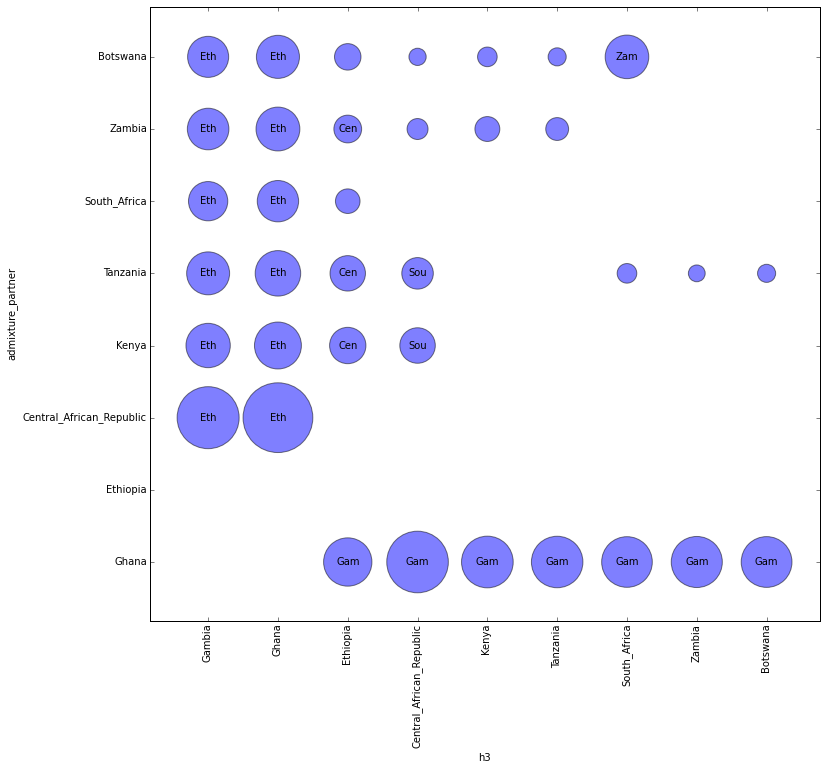

In [271]:
prefix = "163_mac_anc_der_CAE1_24"
name = "countries"
dstat_df = load_result(prefix, name)
dstat_df = add_partner_control(dstat_df)

outgroup='macaque'
dstat_df_og = dstat_df[dstat_df['o']==outgroup]
dstat_df_non_carib = dstat_df_og[~dstat_df_og[['h1','h2','h3']].applymap(lambda c: c in caribbean).any(axis=1)]

gene_flow = dstat_df_non_carib.groupby(['admixture_partner','h3']).apply(max_over_control_ingroups)

pop_tree_order = [c.name for c in tree.get_terminals()]
order = [o for o in pop_tree_order if o not in ['macaque']+caribbean]
fig = plt.figure(figsize=(12,11))

stat = '|dstat|'
pop_order=order
pop_order_x = None

d = gene_flow[stat].unstack()
max_control = gene_flow["max_control"].unstack()
if pop_order_x is not None and pop_order_y is not None:
    d = d.loc[pop_order_x,pop_order_y]
    max_control = max_control.loc[pop_order_x,pop_order_y]
elif pop_order is not None:
    d = d.loc[pop_order,pop_order]
    max_control = max_control.loc[pop_order,pop_order]



#     d = np.ma.array(pw_df.values, mask=pw_df.isnull().values)
#     plt.pcolor(d)
#     plt.colorbar()


ax = plt.gca()
tick_locations = np.arange(0.5, len(d)+1)
ax.set_xticks(tick_locations)
ax.set_yticks(tick_locations)
ax.set_xticklabels(d.columns, rotation='vertical')
ax.set_yticklabels(d.index)
ax.set_xlabel(d.columns.name)
ax.set_ylabel(d.index.name)

color = []
x_vals = []
y_vals = []
sizes = []
for x in range(max_control.shape[1]):
    for y in range(max_control.shape[0]):
        size = d.iloc[y,x]
        if not np.isnan(size):
            x_vals.append(x)
            y_vals.append(y)
            sizes.append(size)
        if size > 0.03:
            try:
                text = max_control.iloc[y,x][:3]
                plt.annotate(text,(x+0.5,y+0.5),horizontalalignment='center', verticalalignment='center')
            except TypeError:
                pass
            
bubbles = plt.scatter(np.array(x_vals)+0.5,np.array(y_vals)+0.5,s=np.array(sizes)*25000)#10**()
bubbles.set_alpha(0.5)

In [282]:
import scipy

In [400]:
countries_dic = {s:" ".join(s.split('_')) for s in set(list(d.columns) + list(d.index))}

In [409]:
country_to_three_letter
for k,v in countries_dic.iteritems():
    if v == "Tanzania":
        v = "Tanzania, United Republic of"
    c = pycountry.countries.get(name=v)
    print c.alpha3

GHA
CAF
ZAF
GMB
TZA
ZMB
ETH
KEN
BWA


In [25]:
dstat_df_og.loc[:,["h1","h2","h3","dstat","Z"]].to_excel(jn(manuscript_dir2,"supplement/data","Data_S2.xlsx"),
                                                                       index=False)

In [26]:
with open(jn(manuscript_dir2,"supplement/data","Data_S2.README"),'w') as f:
    f.write("""\
Results for all D-statistics (ABBA-BABA test) comparisons
that are consistent with the clustering tree of pairwise differences.
Z-scores were obtained through block-jackknifing.
Samples were grouped by country. Fig. 2C shows a subset of the data.
""")

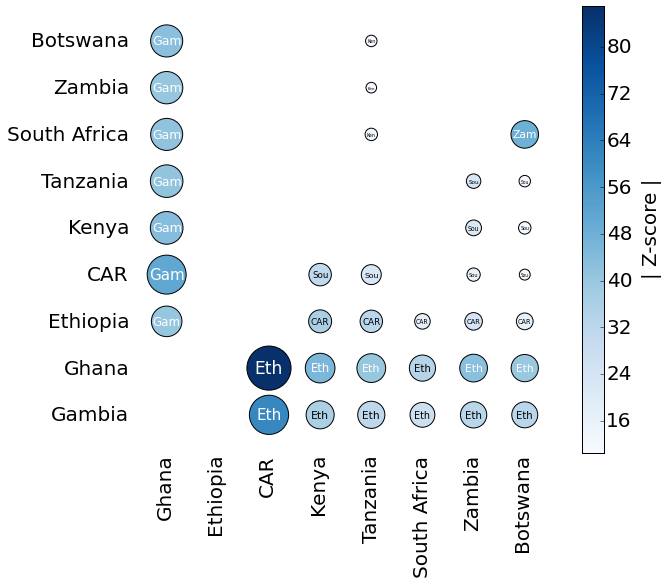

In [30]:
mpl.rcParams["font.size"] = 20

prefix = "163_mac_anc_der_CAE1_24"
name = "countries"
dstat_df = load_result(prefix, name)
dstat_df = add_partner_control(dstat_df)

outgroup='macaque'
dstat_df_og = dstat_df[dstat_df['o']==outgroup]
dstat_df_non_carib = dstat_df_og[~dstat_df_og[['h1','h2','h3']].applymap(lambda c: c in caribbean).any(axis=1)]

gene_flow = dstat_df_non_carib.groupby(['admixture_partner','h3']).apply(max_over_control_ingroups)

pop_tree_order = [c.name for c in tree.get_terminals()]
order = [o for o in pop_tree_order if o not in ['macaque']+caribbean]

fig = plt.figure(figsize=(9.5,8))

stat = '|dstat|'
pop_order=order
pop_order_x = None

d = gene_flow[stat].unstack()
max_control = gene_flow["max_control"].unstack()
if pop_order_x is not None and pop_order_y is not None:
    d = d.loc[pop_order_x,pop_order_y]
    max_control = max_control.loc[pop_order_x,pop_order_y]
elif pop_order is not None:
    d = d.loc[pop_order,pop_order]
    max_control = max_control.loc[pop_order,pop_order]


d = d#.iloc[::-1,::-1]
max_control = max_control#.iloc[::-1,::-1]
    
z = gene_flow["|Z|"].unstack()
z = z.loc[d.index,d.columns]

d.rename(index={"Central_African_Republic":"CAR","South_Africa":"South Africa"},
         columns={"Central_African_Republic":"CAR","South_Africa":"South Africa"},inplace=True)


d = d.T
max_control = max_control.T
z = z.T

ax = plt.gca()
tick_locations = np.arange(0.5, len(d)+1)
ax.set_xticks(tick_locations)
ax.set_yticks(tick_locations)
ax.set_xticklabels(d.columns, rotation='vertical')
ax.set_yticklabels(d.index)
#ax.set_xlabel("p1")
#ax.set_ylabel("p0")

color = []
x_vals = []
y_vals = []
z_scores = []
sizes = []


max_z = z.max().max()
min_z = z.min().min()
half_z = (max_z - min_z)/2.

pos = 0
for x in range(max_control.shape[1]):
    #plot grey stripes x
    #if not x%2:   
    #    plt.axhspan(0,max_control.shape[0],pos, pos + max_control.shape[1], facecolor='grey', alpha=0.1)
    #    pos =  pos + max_control.shape[1]
        
    for y in range(max_control.shape[0]):
        size = d.iloc[y,x]
        if not np.isnan(size):
            x_vals.append(x)
            y_vals.append(y)
            sizes.append(size)
            z_scores.append(z.iloc[y,x]) 
        if size > 0.01:
            try:
                text = max_control.iloc[y,x][:3]
                if text == "Cen":
                    text = "CAR"
                plt.annotate(text,(x+0.5,y+0.5),horizontalalignment='center', verticalalignment='center',
                              color='k' if z.iloc[y,x] < half_z else 'w', fontsize=14*np.sqrt(size/0.13))
                             #color='w',fontsize=16)
            except TypeError:
                pass


#plt.axhspan(ymin=0,ymax=8,xmin=0.1,xmax=0.2, facecolor='grey', alpha=0.1,linewidth=0)
            
#pos = 0
#for i,((pop,country),df) in enumerate(admix.groupby(level=[0,1])):
#    if not i%2:   
#        plt.axvspan(pos, pos + len(df), facecolor='grey', alpha=0.1, ymin=0.1)
#    pos =  pos + len(df)
            
            
            
jet = cm = plt.get_cmap('Blues') 
#cNorm  = mpl.colors.LogNorm(vmin=min(z_scores), vmax=max(z_scores))
cNorm  = mpl.colors.Normalize(vmin=min(z_scores), vmax=max(z_scores))
#scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)

norm_sizes = np.array(sizes)*10000

bubbles = plt.scatter(np.array(x_vals)+0.5,np.array(y_vals)+0.5,
                      c=z_scores,cmap=jet,norm=cNorm,s=norm_sizes)

cb = plt.colorbar(label="| Z-score |")
cb.solids.set_rasterized(True) 
cb.ax.yaxis.labelpad = 10
#bubbles.set_alpha(0.5)

#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
#plt.scatter(np.nan,np.nan,s=[max(norm_sizes)],label=[str(max(norm_sizes))])
#plt.scatter(1,1,label="nix")
#plt.legend(numpoints=1)

#ax.add_patch(
#    mpl.patches.Rectangle((1, 5),   # (x,y)
#        3,          # width
#        1,          # height
#    color='k',linewidth=1,fill=False))


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)


#plt.savefig(jn(manuscript_dir2,"images","abba_baba_overview.svg"),bbox_inches='tight',legend=False,transparent=True)

In [33]:
gene_flow['pval'] = scipy.stats.norm.sf(gene_flow['|Z|'])*2 

In [34]:
gene_flow

|Z|  |dstat|  \
admixture_partner        h3                                             
Botswana                 Central_African_Republic  10.599543   0.0119   
                         Ethiopia                  16.684793   0.0281   
                         Gambia                    32.917666   0.0674   
                         Ghana                     40.047672   0.0742   
                         Kenya                     12.199635   0.0154   
                         South_Africa              48.046652   0.0760   
                         Tanzania                  11.487640   0.0131   
Central_African_Republic Gambia                    61.448636   0.1538   
                         Ghana                     86.975625   0.1946   
Ghana                    Botswana                  43.064563   0.1031   
                         Central_African_Republic  51.247632   0.1517   
                         Ethiopia                  40.694545   0.0934   
                         Kenya                     43.432569   0.1068   
                         South_Africa              41.853565   0.1026   
                         Tanzania                  41.362568   0.1060   
                         Zambia                    40.567566   0.1043   
Kenya                    Central_African_Republic  31.060603   0.0504   
                         Ethiopia                  36.440595   0.0528   
                         Gambia                    36.124761   0.0786   
                         Ghana                     45.550782   0.0881   
South_Africa             Ethiopia                  17.587799   0.0242   
                         Gambia                    27.552764   0.0617   
                         Ghana                     33.814781   0.0684   
Tanzania                 Botswana                  10.714623   0.0131   
                         Central_African_Republic  22.630602   0.0398   
                         Ethiopia                  32.567728   0.0502   
                         Gambia                    31.761655   0.0738   
                         Ghana                     40.443660   0.0828   
                         South_Africa              12.830621   0.0154   
                         Zambia                    10.540629   0.0113   
Zambia                   Central_African_Republic  14.896589   0.0176   
                         Ethiopia                  24.076795   0.0308   
                         Gambia                    32.668765   0.0691   
                         Ghana                     42.843783   0.0769   
                         Kenya                     21.672697   0.0248   
                         Tanzania                  23.293699   0.0209   

                                                                max_control  \
admixture_partner        h3                                                   
Botswana                 Central_African_Republic              South_Africa   
                         Ethiopia                  Central_African_Republic   
                         Gambia                                    Ethiopia   
                         Ghana                                     Ethiopia   
                         Kenya                                 South_Africa   
                         South_Africa                                Zambia   
                         Tanzania                              South_Africa   
Central_African_Republic Gambia                                    Ethiopia   
                         Ghana                                     Ethiopia   
Ghana                    Botswana                                    Gambia   
                         Central_African_Republic                    Gambia   
                         Ethiopia                                    Gambia   
                         Kenya                                       Gambia   
                         South_Africa                                Gambia   
                  

In [ ]:
p_vals = scipy.stats.norm.sf(z_scores)*2 

In [ ]:
0.1946 Ghana CAR
0.15 CAR Ghana
0.10 South Africa Ghana
0.05 Ethiopia Tansania
0.01 Zamiba Kenya

In [518]:
d

h3,Botswana,Zambia,South Africa,Tanzania,Kenya,CAR,Ethiopia,Ghana,Gambia
admixture_partner,,,,,,,,,
Botswana,NaN,NaN,0.0825,0.0079,0.0104,0.0060,0.1195,0.0178,NaN
Zambia,NaN,NaN,NaN,0.0147,0.0189,0.0105,0.1209,0.0198,NaN
South Africa,NaN,NaN,NaN,NaN,NaN,NaN,0.1205,0.0172,NaN
Tanzania,0.0194,0.0175,0.0219,NaN,NaN,0.0321,0.1373,0.0226,NaN
Kenya,NaN,NaN,NaN,NaN,NaN,0.0386,0.1358,0.0240,NaN
CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0930,NaN
Ethiopia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ghana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


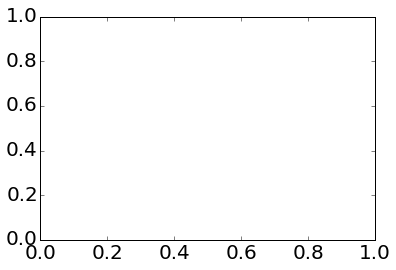

In [478]:
ax = plt.gca()
ax.add_patch(
    mpl.patches.Rectangle((1, 5),   # (x,y)
        3,          # width
        1,          # height
    color='k',linewidth=1,fill=False))

In [465]:
d.iloc[::-1,::-1]

h3,Botswana,Zambia,South Africa,Tanzania,Kenya,CAR,Ethiopia,Ghana,Gambia
admixture_partner,,,,,,,,,
Botswana,NaN,NaN,0.0825,0.0079,0.0104,0.0060,0.1195,0.0178,NaN
Zambia,NaN,NaN,NaN,0.0147,0.0189,0.0105,0.1209,0.0198,NaN
South Africa,NaN,NaN,NaN,NaN,NaN,NaN,0.1205,0.0172,NaN
Tanzania,0.0194,0.0175,0.0219,NaN,NaN,0.0321,0.1373,0.0226,NaN
Kenya,NaN,NaN,NaN,NaN,NaN,0.0386,0.1358,0.0240,NaN
CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0930,NaN
Ethiopia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ghana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


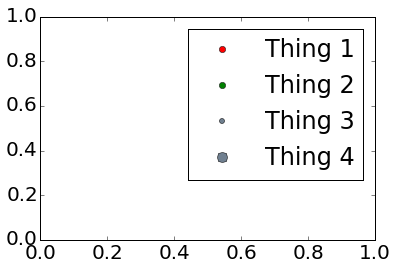

In [442]:
line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line2 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="green")
line3 = Line2D(range(1), range(1), color="white", marker='o',markersize=5, markerfacecolor="slategray")
line4 = Line2D(range(1), range(1), color="white", marker='o',markersize=10,markerfacecolor="slategray")
plt.legend((line1,line2,line3,line4),('Thing 1','Thing 2', 'Thing 3', 'Thing 4'),numpoints=1, loc=1)

In [353]:
p_vals = scipy.stats.norm.sf(z_scores)*2 

In [544]:
import scipy.stats as st
st.poisson.ppf(30,.95)

nan

In [549]:
st.poisson.ppf([0.05,0.95],30)

array([ 21.,  39.])

In [ ]:
p_vals[p_vals==0] = min(p_vals[p_vals!=0])

In [357]:
scipy.stats.norm.sf(z_scores)*2

In [342]:
z_scores = np.arange(37,38,0.001)
p_vals = scipy.stats.norm.sf(z_scores)*2
p_vals

array([  1.14511424e-299,   1.10348894e-299,   1.06337566e-299,
         1.02471953e-299,   9.87467656e-300,   9.51569055e-300,
         9.16974602e-300,   8.83636953e-300,   8.51510482e-300,
         8.20551215e-300,   7.90716777e-300,   7.61966329e-300,
         7.34260513e-300,   7.07561399e-300,   6.81832435e-300,
         6.57038394e-300,   6.33145326e-300,   6.10120514e-300,
         5.87932431e-300,   5.66550688e-300,   5.45946005e-300,
         5.26090161e-300,   5.06955959e-300,   4.88517192e-300,
         4.70748600e-300,   4.53625843e-300,   4.37125463e-300,
         4.21224854e-300,   4.05902230e-300,   3.91136596e-300,
         3.76907721e-300,   3.63196104e-300,   3.49982955e-300,
         3.37250167e-300,   3.24980288e-300,   3.13156500e-300,
         3.01762596e-300,   2.90782958e-300,   2.80202535e-300,
         2.70006821e-300,   2.60181838e-300,   2.50714114e-300,
         2.41590670e-300,   2.32798993e-300,   2.24327028e-300,
         2.16163157e-300,   2.08296183e-

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [309]:
p_vals

array([  3.21380261e-83,   4.41265144e-41,   8.85693839e-37,
         9.07193822e-21,   1.64098308e-24,   6.11681736e-18,
         3.21380261e-83,   3.21380261e-83,   3.21380261e-83,
         3.21380261e-83,   3.21380261e-83,   3.21380261e-83,
         2.86679401e-43,   2.41411663e-11,   1.02557509e-04,
         1.66719731e-62,   3.77313378e-14,   1.08081630e-61,
         1.01336752e-11,   1.14006590e-42,   3.21380261e-83,
         7.02531028e-44,   2.32616090e-43])

In [302]:
scores = -np.log10(p_vals)

array([         inf,  40.35530038,  36.05271638,  20.04229992,
        23.7848959 ,  17.21347449,          inf,          inf,
                inf,          inf,          inf,  82.4929808 ,
        42.54260351,  10.61724175,   3.98903254,  61.778013  ,
        13.4232978 ,  60.96624812,  10.99423302,  41.94307004,
                inf,  43.15333449,  42.63336025])

In [292]:
import sys
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

In [ ]:
%%bash
qsub 